# **Steering Angle prediction with CNN**

## Libraries

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
import cv2
import random
from PIL import Image
import time

## Import Data


### *Get Data*
The **data** dataframe contains image paths, and driving log including steering angel, throttle, brake and speed

In [2]:
def getName(filePath):
    a = filePath.split('\\')[-1]
    b = filePath.split('\\')[-2]
    c = filePath.split('\\')[-3]
    return c + '/' + b +'/' + a

def importDataInfo(path):
    columns = ['Center', 'Left', 'Right', 'Steering', 'Throttle', 'Brake', 'Speed']
    data = pd.read_csv(os.path.join(path, 'driving_log.csv'), names=columns)
    #### REMOVE FILE PATH AND GET ONLY FILE NAME
    data['Center'] = data['Center'].apply(getName)
    data['Left'] = data['Left'].apply(getName)
    data['Right'] = data['Right'].apply(getName)

    print('Total Images Imported', data.shape[0])
    return data

path = 'Dataset'
data = importDataInfo(path)
data

Total Images Imported 10491


,Center,Left,Right,Steering,Throttle,Brake,Speed
0,Dataset/IMG/center_2023_01_22_17_25_18_013.jpg,Dataset/IMG/left_2023_01_22_17_25_18_013.jpg,Dataset/IMG/right_2023_01_22_17_25_18_013.jpg,0.0,0.0,0.0,14.65444
1,Dataset/IMG/center_2023_01_22_17_25_18_091.jpg,Dataset/IMG/left_2023_01_22_17_25_18_091.jpg,Dataset/IMG/right_2023_01_22_17_25_18_091.jpg,0.0,0.0,0.0,14.53191
2,Dataset/IMG/center_2023_01_22_17_25_18_178.jpg,Dataset/IMG/left_2023_01_22_17_25_18_178.jpg,Dataset/IMG/right_2023_01_22_17_25_18_178.jpg,0.0,0.0,0.0,13.82092
3,Dataset/IMG/center_2023_01_22_17_25_18_259.jpg,Dataset/IMG/left_2023_01_22_17_25_18_259.jpg,Dataset/IMG/right_2023_01_22_17_25_18_259.jpg,0.0,0.0,0.0,13.80480
4,Dataset/IMG/center_2023_01_22_17_25_18_335.jpg,Dataset/IMG/left_2023_01_22_17_25_18_335.jpg,Dataset/IMG/right_2023_01_22_17_25_18_335.jpg,0.0,0.0,0.0,14.19830
...,...,...,...,...,...,...,...
10486,Dataset/IMG/center_2023_01_22_17_53_13_321.jpg,Dataset/IMG/left_2023_01_22_17_53_13_321.jpg,Dataset/IMG/right_2023_01_22_17_53_13_321.jpg,0.0,0.0,0.0,27.72017
10487,Dataset/IMG/center_2023_01_22_17_53_13_414.jpg,Dataset/IMG/left_2023_01_22_17_53_13_414.jpg,Dataset/IMG/right_2023_01_22_17_53_13_414.jpg,0.0,0.0,0.0,27.44341
10488,Dataset/IMG/center_2023_01_22_17_53_13_490.jpg,Dataset/IMG/left_2023_01_22_17_53_13_490.jpg,Dataset/IMG/right_2023_01_22_17_53_13_490.jpg,0.0,0.0,0.0,27.22400
10489,Dataset/IMG/center_2023_01_22_17_53_13_557.jpg,Dataset/IMG/left_2023_01_22_17_53_13_557.jpg,Dataset/IMG/right_2023_01_22_17_53_13_557.jpg,0.0,0.0,0.0,27.06060


In [187]:
# img = mpimg.imread(data['Center'][0])
# imgplot = plt.imshow(img)
# plt.show()

### *Balancing Data*

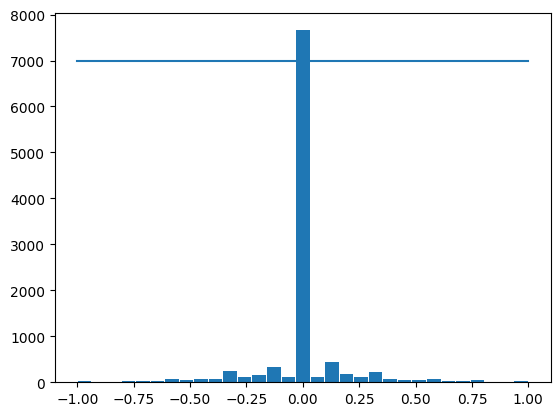

Removed Images: 658
Remaining Images: 9833


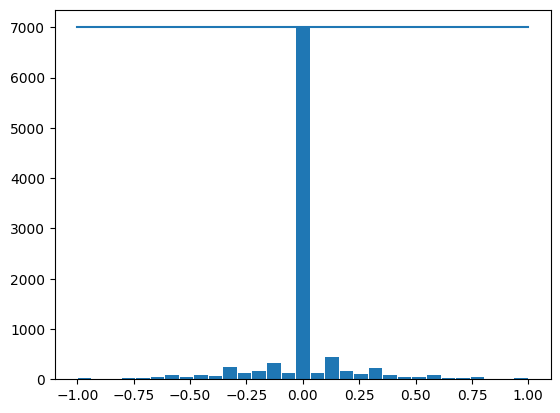

9833


In [189]:

def balanceData(data,display=True):
    nBin = 31
    # samplesPerBin = 500
    samplesPerBin = 7000
    hist, bins = np.histogram(data['Steering'], nBin)
    if display:
        center = (bins[:-1] + bins[1:]) * 0.5
        plt.bar(center, hist, width=0.06)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.show()
    removeindexList = []
    for j in range(nBin):
        binDataList = []
        for i in range(len(data['Steering'])):
            if data['Steering'][i] >= bins[j] and data['Steering'][i] <= bins[j + 1]:
                binDataList.append(i)
        binDataList = shuffle(binDataList)
        binDataList = binDataList[samplesPerBin:]
        removeindexList.extend(binDataList)

    print('Removed Images:', len(removeindexList))
    # print(type(removeindexList))
    # print(removeindexList)
    data.drop(data.index[removeindexList], inplace=True)
    print('Remaining Images:', len(data))
    # print(type(data))

    if display:
        hist, _ = np.histogram(data['Steering'], (nBin))
        plt.bar(center, hist, width=0.06)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.show()
    return data

data = balanceData(data, display=True)
# data = pd.DataFrame(data)
print(len(data))
# print(data)


### *Spliting training validating data*

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

numpydata = data.values
# print(numpydata[:,:])
xTrain, xVal, yTrain, yVal = train_test_split(numpydata[:,:1], numpydata[:,3:6], test_size=0.2,random_state=10)
print('Total Training Images: ',len(xTrain))
print('Total Validation Images: ',len(xVal))

yTrain = np.asarray(yTrain).astype(np.float32)
yVal = np.asarray(yVal).astype(np.float32)

Total Training Images:  8392
Total Validation Images:  2099


## Preprocessing

### *Image Preprocessing*

In [6]:
# Functions for preprocessing
def preProcess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255

    # im = Image.fromarray(img,'RGB')
    # im.show()
    # time.sleep(1)
    return img

### *Image Augmentation*

In [7]:
# Function for image augmentation
def augmentImage(imgPath,val):
    img =  mpimg.imread(imgPath)
    if np.random.rand() < 0.5:
        pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
        img = pan.augment_image(img)
    if np.random.rand() < 0.5:
        zoom = iaa.Affine(scale=(1, 1.2))
        img = zoom.augment_image(img)
    if np.random.rand() < 0.5:
        brightness = iaa.Multiply((0.2, 1.2))
        img = brightness.augment_image(img)
    # if np.random.rand() < 0.5:
    #     img = cv2.flip(img, 1)
    #     val[0] = -val[0]
    return img, val


### *Batch generation*

In [8]:
# Functions for batch generation
def batchGen(imagesPath, val, batchSize, trainFlag):
    while True:
        imgBatch = []
        driving_log = []

        for i in range(batchSize):
            index = random.randint(0, len(imagesPath) - 1)
            if trainFlag:
                img, output = augmentImage(imagesPath[index][0], val[:][index])
            else:
                img = mpimg.imread(imagesPath[index][0])
                output = val[:][index]
            img = preProcess(img)
            imgBatch.append(img)
            driving_log.append(output)
        yield (np.asarray(imgBatch), np.asarray(driving_log))

## CNN Model for Steering Angle Prediction

### *Creating neural network*

In [1]:
import tensorflow as tf

input_layer = tf.keras.layers.Input(shape=(66, 200, 3))
# input_layer = tf.keras.models.Sequential()
conv = (tf.keras.layers.Conv2D(24, (5, 5), (2, 2), input_shape=(66, 200, 3), activation='elu'))(input_layer)
conv = (tf.keras.layers.Conv2D(36, (5, 5), (2, 2), activation='elu'))(conv)
conv = (tf.keras.layers.Conv2D(48, (5, 5), (2, 2), activation='elu'))(conv)
conv = (tf.keras.layers.Conv2D(64, (3, 3), activation='elu'))(conv)
conv = (tf.keras.layers.Conv2D(64, (3, 3), activation='elu'))(conv)

flatten = (tf.keras.layers.Flatten())(conv)

dense = (tf.keras.layers.Dense(100, activation='elu'))(flatten)
dense = (tf.keras.layers.Dense(50, activation='elu'))(dense)
dense = (tf.keras.layers.Dense(10, activation='elu'))(dense)

steering_output = tf.keras.layers.Dense(1, activation='linear', name = "steering_prediction")(dense)
# throttle_output = tf.keras.layers.Dense(1, activation='linear', name = "throttle_prediction")(dense)
# brake_output = tf.keras.layers.Dense(1, activation='linear', name = "brake_prediction")(dense)
# speed_output = tf.keras.layers.Dense(1, activation='elu', name = "speed_prediction")(dense)

# output_list = [steering_output, throttle_output, brake_output, speed_output]
output_list = [steering_output]

Model = tf.keras.Model(inputs = input_layer, outputs = output_list)
# model_1.add(output_list)

Model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss=['mse','mse','mse','mse'], metrics='acc')
tf.keras.utils.plot_model(Model, show_shapes=True)


NameError: name 'throttle_output' is not defined

### *Model Summary*

In [194]:
Model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 66, 200, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 31, 98, 24)   1824        ['input_12[0][0]']               
                                                                                                  
 conv2d_56 (Conv2D)             (None, 14, 47, 36)   21636       ['conv2d_55[0][0]']              
                                                                                                  
 conv2d_57 (Conv2D)             (None, 5, 22, 48)    43248       ['conv2d_56[0][0]']       

### *train model*

In [ ]:
history = Model.fit(batchGen(xTrain, yTrain, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=10,
                                  validation_data=batchGen(xVal, yVal, 100, 0),
                                  validation_steps=200)

Model.save('Model1.h5')
print('Model Saved')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

Epoch 1/10
300/300 [==============================] - 312s 1s/step - loss: 0.3161 - steering_prediction_loss: 0.1060 - throttle_prediction_loss: 0.1051 - brake_prediction_loss: 0.1050 - steering_prediction_acc: 0.7021 - throttle_prediction_acc: 0.7021 - brake_prediction_acc: 0.7021 - val_loss: 0.3065 - val_steering_prediction_loss: 0.1023 - val_throttle_prediction_loss: 0.1023 - val_brake_prediction_loss: 0.1018 - val_steering_prediction_acc: 0.6971 - val_throttle_prediction_acc: 0.6971 - val_brake_prediction_acc: 0.6971
Epoch 2/10
300/300 [==============================] - 283s 946ms/step - loss: 0.3100 - steering_prediction_loss: 0.1035 - throttle_prediction_loss: 0.1032 - brake_prediction_loss: 0.1033 - steering_prediction_acc: 0.7032 - throttle_prediction_acc: 0.7032 - brake_prediction_acc: 0.7032 - val_loss: 0.3053 - val_steering_prediction_loss: 0.1019 - val_throttle_prediction_loss: 0.1019 - val_brake_prediction_loss: 0.1016 - val_steering_prediction_acc: 0.7004 - val_throttle_p

## CNN Model 2

#### *Creating Neural Network*

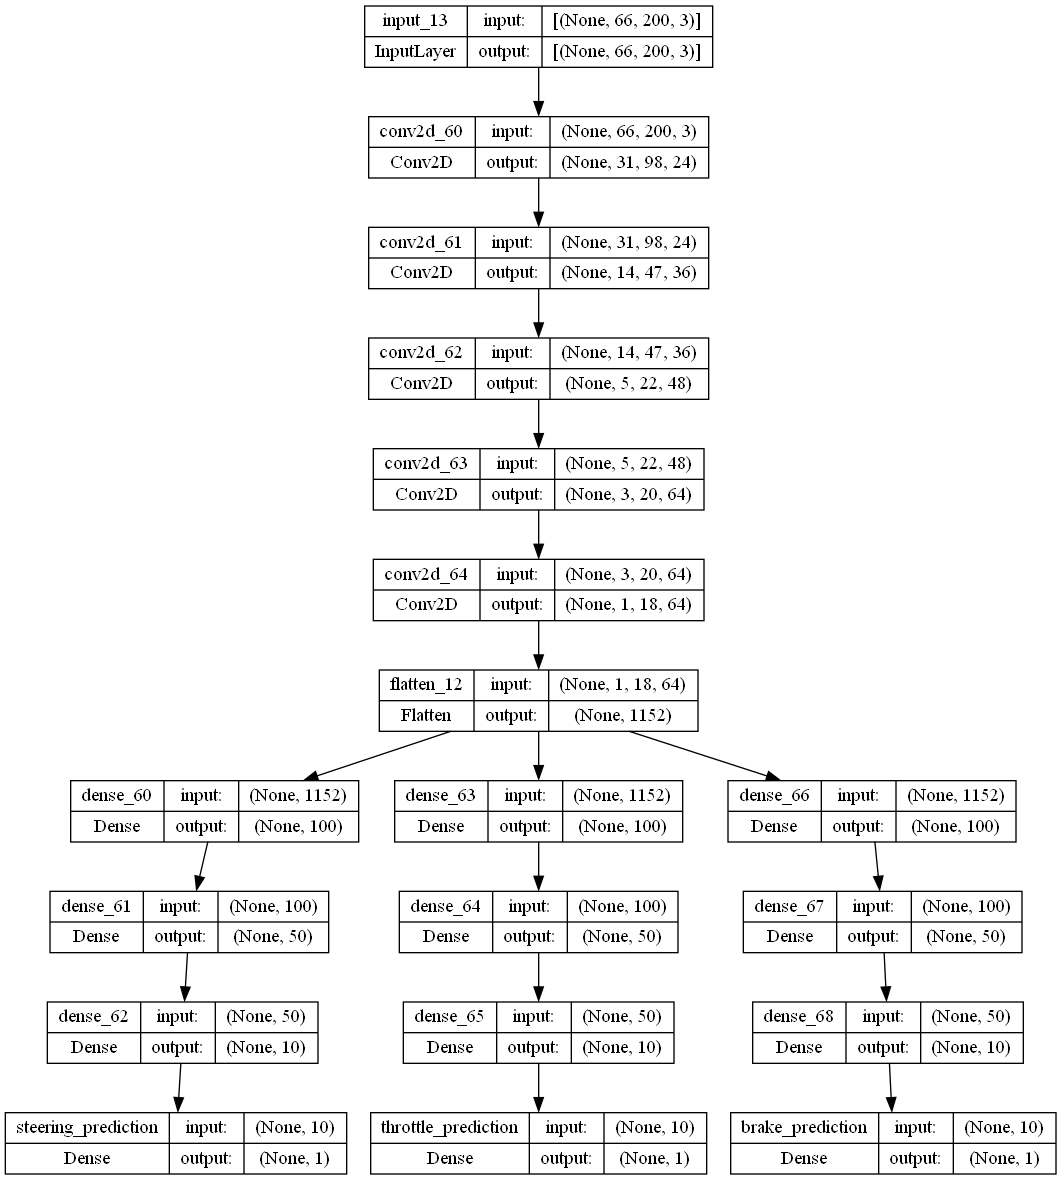

In [195]:
import tensorflow as tf

input_layer = tf.keras.layers.Input(shape=(66, 200, 3))
# input_layer = tf.keras.models.Sequential()
conv = (tf.keras.layers.Conv2D(24, (5, 5), (2, 2), input_shape=(66, 200, 3), activation='elu'))(input_layer)
conv = (tf.keras.layers.Conv2D(36, (5, 5), (2, 2), activation='elu'))(conv)
conv = (tf.keras.layers.Conv2D(48, (5, 5), (2, 2), activation='elu'))(conv)
conv = (tf.keras.layers.Conv2D(64, (3, 3), activation='elu'))(conv)
conv = (tf.keras.layers.Conv2D(64, (3, 3), activation='elu'))(conv)

flatten = (tf.keras.layers.Flatten())(conv)

dense = (tf.keras.layers.Dense(100, activation='elu'))(flatten)
dense = (tf.keras.layers.Dense(50, activation='elu'))(dense)
dense = (tf.keras.layers.Dense(10, activation='elu'))(dense)
steering_output = tf.keras.layers.Dense(1, activation='linear', name = "steering_prediction")(dense)

dense = (tf.keras.layers.Dense(100, activation='elu'))(flatten)
dense = (tf.keras.layers.Dense(50, activation='elu'))(dense)
dense = (tf.keras.layers.Dense(10, activation='elu'))(dense)
throttle_output = tf.keras.layers.Dense(1, activation='linear', name = "throttle_prediction")(dense)

dense = (tf.keras.layers.Dense(100, activation='elu'))(flatten)
dense = (tf.keras.layers.Dense(50, activation='elu'))(dense)
dense = (tf.keras.layers.Dense(10, activation='elu'))(dense)
brake_output = tf.keras.layers.Dense(1, activation='linear', name = "brake_prediction")(dense)
# speed_output = tf.keras.layers.Dense(1, activation='elu', name = "speed_prediction")(dense)

# output_list = [steering_output, throttle_output, brake_output, speed_output]
output_list = [steering_output, throttle_output, brake_output]

Model2 = tf.keras.Model(inputs = input_layer, outputs = output_list)
# model_1.add(output_list)

Model2.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss=['mse','mse','mse','mse'], metrics='acc')
tf.keras.utils.plot_model(Model2, show_shapes=True)


#### *train Model*

In [196]:
yTrain = np.asarray(yTrain).astype(np.float32)
yVal = np.asarray(yVal).astype(np.float32)

history = Model2.fit(batchGen(xTrain, yTrain, 10, 1),
                                  steps_per_epoch=100,
                                  epochs=3,
                                  validation_data=batchGen(xVal, yVal, 10, 0),
                                  validation_steps=100)

Model.save('Model2.h5')
print('Model Saved')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

Epoch 1/3
 24/100 [======>.......................] - ETA: 5s - loss: 0.3282 - steering_prediction_loss: 0.1058 - throttle_prediction_loss: 0.1148 - brake_prediction_loss: 0.1075 - steering_prediction_acc: 0.7125 - throttle_prediction_acc: 0.7125 - brake_prediction_acc: 0.7125

KeyboardInterrupt: 

## CNN Model 3

#### *Creating Neural Network*

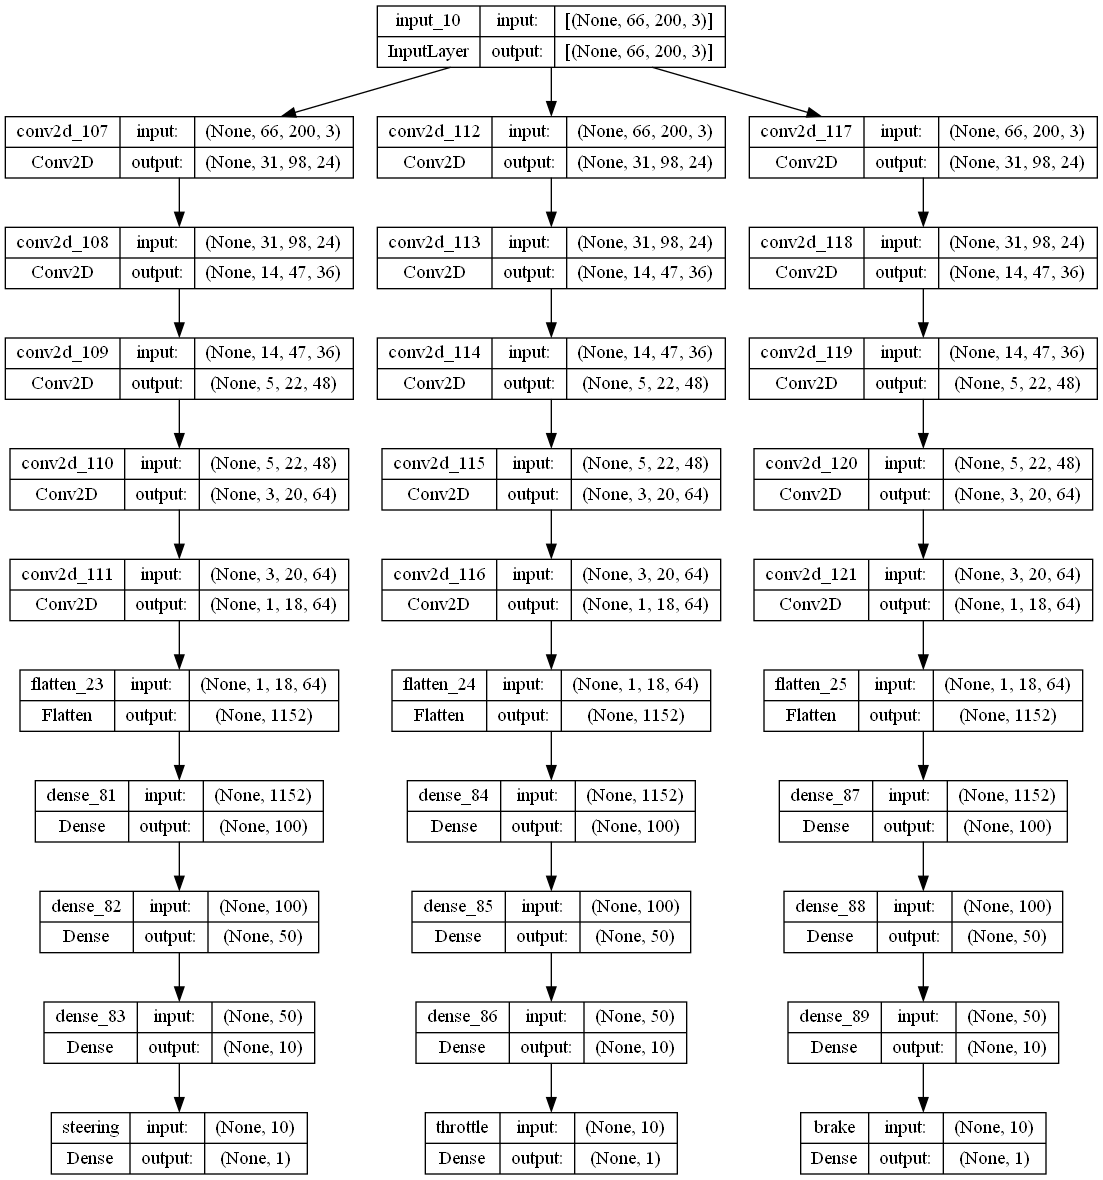

In [57]:
import tensorflow as tf

input_layer = tf.keras.layers.Input(shape=(66, 200, 3))
# input_layer = tf.keras.models.Sequential()
conv = (tf.keras.layers.Conv2D(24, (5, 5), (2, 2), input_shape=(66, 200, 3), activation='elu'))(input_layer)
conv = (tf.keras.layers.Conv2D(36, (5, 5), (2, 2), activation='elu'))(conv)
conv = (tf.keras.layers.Conv2D(48, (5, 5), (2, 2), activation='elu'))(conv)
conv = (tf.keras.layers.Conv2D(64, (3, 3), activation='elu'))(conv)
conv = (tf.keras.layers.Conv2D(64, (3, 3), activation='elu'))(conv)
flatten = (tf.keras.layers.Flatten())(conv)
dense = (tf.keras.layers.Dense(100, activation='elu'))(flatten)
dense = (tf.keras.layers.Dense(50, activation='elu'))(dense)
dense = (tf.keras.layers.Dense(10, activation='elu'))(dense)
steering_output = tf.keras.layers.Dense(1, activation='linear', name = "steering")(dense)



conv = (tf.keras.layers.Conv2D(24, (5, 5), (2, 2), input_shape=(66, 200, 3), activation='elu'))(input_layer)
conv = (tf.keras.layers.Conv2D(36, (5, 5), (2, 2), activation='elu'))(conv)
conv = (tf.keras.layers.Conv2D(48, (5, 5), (2, 2), activation='elu'))(conv)
conv = (tf.keras.layers.Conv2D(64, (3, 3), activation='elu'))(conv)
conv = (tf.keras.layers.Conv2D(64, (3, 3), activation='elu'))(conv)
flatten = (tf.keras.layers.Flatten())(conv)
dense = (tf.keras.layers.Dense(100, activation='elu'))(flatten)
dense = (tf.keras.layers.Dense(50, activation='elu'))(dense)
dense = (tf.keras.layers.Dense(10, activation='elu'))(dense)
throttle_output = tf.keras.layers.Dense(1, activation='linear', name = "throttle")(dense)



conv = (tf.keras.layers.Conv2D(24, (5, 5), (2, 2), input_shape=(66, 200, 3), activation='elu'))(input_layer)
conv = (tf.keras.layers.Conv2D(36, (5, 5), (2, 2), activation='elu'))(conv)
conv = (tf.keras.layers.Conv2D(48, (5, 5), (2, 2), activation='elu'))(conv)
conv = (tf.keras.layers.Conv2D(64, (3, 3), activation='elu'))(conv)
conv = (tf.keras.layers.Conv2D(64, (3, 3), activation='elu'))(conv)
flatten = (tf.keras.layers.Flatten())(conv)
dense = (tf.keras.layers.Dense(100, activation='elu'))(flatten)
dense = (tf.keras.layers.Dense(50, activation='elu'))(dense)
dense = (tf.keras.layers.Dense(10, activation='elu'))(dense)
brake_output = tf.keras.layers.Dense(1, activation='linear', name = "brake")(dense)


output_list = [steering_output, throttle_output, brake_output]


Model3 = tf.keras.Model(inputs = input_layer, outputs = output_list)
Model3.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss=['mse','mse','mse','mse'], metrics='acc')
tf.keras.utils.plot_model(Model3, show_shapes=True)


#### *train Model*

Epoch 1/10
300/300 [==============================] - 764s 3s/step - loss: 0.3219 - steering_loss: 0.1049 - throttle_loss: 0.1078 - brake_loss: 0.1092 - steering_acc: 0.7055 - throttle_acc: 0.7042 - brake_acc: 0.7032 - val_loss: 0.3052 - val_steering_loss: 0.1008 - val_throttle_loss: 0.1018 - val_brake_loss: 0.1026 - val_steering_acc: 0.7049 - val_throttle_acc: 0.7049 - val_brake_acc: 0.7049
Epoch 2/10
300/300 [==============================] - 736s 2s/step - loss: 0.3104 - steering_loss: 0.1029 - throttle_loss: 0.1036 - brake_loss: 0.1039 - steering_acc: 0.7058 - throttle_acc: 0.7058 - brake_acc: 0.7058 - val_loss: 0.3032 - val_steering_loss: 0.1006 - val_throttle_loss: 0.1011 - val_brake_loss: 0.1015 - val_steering_acc: 0.7072 - val_throttle_acc: 0.7072 - val_brake_acc: 0.7072
Epoch 3/10
300/300 [==============================] - 729s 2s/step - loss: 0.3100 - steering_loss: 0.1030 - throttle_loss: 0.1034 - brake_loss: 0.1036 - steering_acc: 0.7042 - throttle_acc: 0.7042 - brake_acc: 

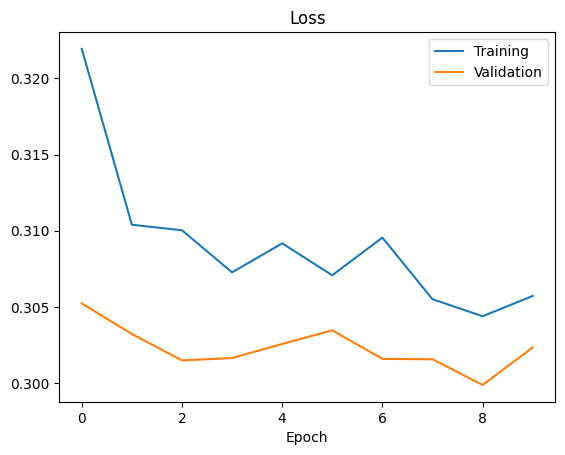

In [58]:
history = Model3.fit(batchGen(xTrain, yTrain, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=10,
                                  validation_data=batchGen(xVal, yVal, 100, 0),
                                  validation_steps=200,
                                  on_epoch_end=)

Model3.save('Model3.h5')
print('Model Saved')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

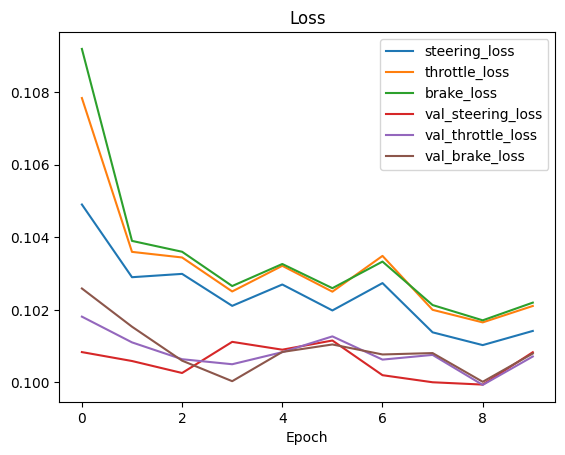

In [59]:
plt.plot(history.history['steering_loss'])
plt.plot(history.history['throttle_loss'])
plt.plot(history.history['brake_loss'])

plt.plot(history.history['val_steering_loss'])
plt.plot(history.history['val_throttle_loss'])
plt.plot(history.history['val_brake_loss'])

plt.legend(['steering_loss', 'throttle_loss', 'brake_loss', 'val_steering_loss', 'val_throttle_loss', 'val_brake_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()


## Test Model

In [60]:
print('Setting UP')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import socketio
import eventlet
import numpy as np
from flask import Flask
from keras.models import load_model
import base64
from io import BytesIO
from PIL import Image
import cv2

Setting UP


In [63]:
def imgProcess(img):
    img = img[60:135, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img / 255
    return img

img = mpimg.imread(xTrain[77][0])
img = imgProcess(img)
img = np.array([img])
img.shape
# print(img)

model = load_model('Model3.h5')
drivingLog = []
drivingLog = (model.predict(img))
# steering = drivingLog[0][0][0]
# throttle = drivingLog[1][0][0]
# brake = drivingLog[2][0][0]
print(drivingLog)

1/1 [==============================] - 1s 747ms/step
[array([[-0.00038021]], dtype=float32), array([[0.01300545]], dtype=float32), array([[0.01458864]], dtype=float32)]


In [64]:
model = load_model('model.h5')
drivingLog = []
steering = (model.predict(img))
print(steering)

1/1 [==============================] - 0s 218ms/step
[[-0.1829028]]


Dataset/IMG/center_2023_01_22_17_29_05_978.jpg
[0.        0.8109397 0.       ]


array([0.       , 0.8109397, 0.       ], dtype=float32)

## **Test with Simulator**

In [1]:
print('Setting UP')
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import socketio
import eventlet
import numpy as np
from flask import Flask
from keras.models import load_model
import base64
from io import BytesIO
from PIL import Image
import cv2

#### FOR REAL TIME COMMUNICATION BETWEEN CLIENT AND SERVER
sio = socketio.Server()
#### FLASK IS A MICRO WEB FRAMEWORK WRITTEN IN PYTHON
app = Flask(__name__)  # '__main__'

maxSpeed = 10


def Process(img):
    img = img[60:135, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img / 255
    return img


@sio.on('telemetry')
def telemetry(sid, data):
    speed = float(data['speed'])

    image = Image.open(BytesIO(base64.b64decode(data['image'])))
    image = np.asarray(image)
    image = Process(image)
    image = np.array([image])

    drivingLog = (model.predict(image))
    steering = drivingLog[0][0][0]
    throttle = 1.0 - speed / maxSpeed
    print(steering)
    # print(f'{steering}, {throttle}, {speed}')
    sendControl(0, 0)


@sio.on('connect')
def connect(sid, environ):
    print('Connected')
    sendControl(0, 0)


def sendControl(steering, throttle):
    sio.emit('steer', data={
        'steering_angle': steering.__str__(),
        'throttle': throttle.__str__()
    })


if __name__ == '__main__':
    model = load_model('Model3.h5')
    app = socketio.Middleware(sio, app)
    ### LISTEN TO PORT 4567
    eventlet.wsgi.server(eventlet.listen(('', 4567)), app)



Setting UP


(8104) wsgi starting up on http://0.0.0.0:4567
(8104) accepted ('127.0.0.1', 8926)


Connected
1/1 [==============================] - 1s 633ms/step
0.19313537
1/1 [==============================] - 0s 52ms/step
0.19313537
1/1 [==============================] - 0s 53ms/step
0.19313537
1/1 [==============================] - 0s 60ms/step
0.1960762
1/1 [==============================] - 0s 53ms/step
0.19311944
1/1 [==============================] - 0s 57ms/step
0.19327013
1/1 [==============================] - 0s 56ms/step
0.19312845
1/1 [==============================] - 0s 56ms/step
0.19431199
1/1 [==============================] - 0s 54ms/step
0.1952631
1/1 [==============================] - 0s 58ms/step
0.19313537
1/1 [==============================] - 0s 53ms/step
0.19363917
1/1 [==============================] - 0s 62ms/step
0.19323377
1/1 [==============================] - 0s 52ms/step
0.19362585
1/1 [==============================] - 0s 53ms/step
0.19366224
1/1 [==============================] - 0s 66ms/step
0.1952631
1/1 [==============================] - 0s 65ms/

Exception in thread Thread-62 (_handle_event_internal):


0.19415471


Traceback (most recent call last):
  File "d:\AppData\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "d:\AppData\Python\Python310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "d:\AppData\Python\Python310\lib\site-packages\socketio\server.py", line 685, in _handle_event_internal
    r = server._trigger_event(data[0], namespace, sid, *data[1:])
  File "d:\AppData\Python\Python310\lib\site-packages\socketio\server.py", line 714, in _trigger_event
    return self.handlers[namespace][event](*args)
  File "C:\Users\Md. Hasibur Rahman\AppData\Local\Temp\ipykernel_8104\1345655518.py", line 41, in telemetry
    drivingLog = (model.predict(image))
  File "d:\AppData\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "d:\AppData\Python\Python310\lib\site-packages\keras\engine\training.py", line 2029, in predict
    for _, iterator i

1/1 [==============================] - 0s 54ms/step
0.19491796
1/1 [==============================] - 0s 71ms/step
0.19364451
1/1 [==============================] - 0s 56ms/step
0.1960762
1/1 [==============================] - 0s 52ms/step
0.1960762
1/1 [==============================] - 0s 58ms/step
0.1952631
1/1 [==============================] - 0s 75ms/step
0.19497319
1/1 [==============================] - 0s 64ms/step
0.19319971
1/1 [==============================] - 0s 75ms/step
0.1960762
1/1 [==============================] - 0s 55ms/step
0.19491796
1/1 [==============================] - 0s 157ms/step
0.1952631
1/1 [==============================] - 0s 49ms/step
0.1944077
1/1 [==============================] - 0s 49ms/step
0.19352473
1/1 [==============================] - 0s 66ms/step
0.19327013
1/1 [==============================] - 0s 56ms/step
0.1952631
1/1 [==============================] - 0s 62ms/step
0.19319971
1/1 [==============================] - 0s 65ms/step
0.1933178